## Задача 5. Экспериментальное исследование алгоритмов для регулярных запросов

## Постановка задачи
1. Достижимость между парами вершин
2. Достижимость для всего множества заданных вершин
3. Достижимость для каждой из заданного множества стартовых вершин.

## Набор данных
Для полноты эксперимента были выбраны несколько графов:
1. [biomedical](https://jetbrains-research.github.io/CFPQ_Data/dataset/data/biomedical.html) - 341 вершина, 459 ребры
2. [funding](https://jetbrains-research.github.io/CFPQ_Data/dataset/data/funding.html) - 778 вершин, 1086 ребер
3. [core](https://jetbrains-research.github.io/CFPQ_Data/dataset/data/core.html) - 1323 вершины, 2752 ребра

Все графы имеют разное число вершин, но при этом они не слишком большие, чтобы суммарное время их выполнения было
в пределах часа.


Регулярные запросы к графам строются по следующему шаблону:
1. (n1 | n2 | n3 )* n0),
* (n0 | n1 | n2 )+ n3),
* (n0 n1)* (n0 n2)*
* n0 n2 (n0 | n3)*

где n0, ..., nk - все метки графа в порядке убывания частоты их появления в графе.

Алгоритм запускался также со следующими вариантами матриц:
1. lil_matrix
2. csr_matrix
3. csc_matrix
4. dok_matrix

Каждая конфигурация запускалась пять раз, среднее время и отклонение можно видеть на диаграмме.
Достижимость между парами вершин:

[2022-10-19 21:32:25]>INFO>Found graph with name='biomedical'


[2022-10-19 21:32:26]>INFO>Load archive graph_archive=WindowsPath('c:/users/slava/documents/github/formal-lang-course/venv/lib/site-packages/cfpq_data/data/biomedical.tar.gz')
[2022-10-19 21:32:26]>INFO>Unzip graph name='biomedical' to file graph=WindowsPath('c:/users/slava/documents/github/formal-lang-course/venv/lib/site-packages/cfpq_data/data/biomedical/biomedical.csv')
[2022-10-19 21:32:26]>INFO>Remove archive graph_archive=WindowsPath('c:/users/slava/documents/github/formal-lang-course/venv/lib/site-packages/cfpq_data/data/biomedical.tar.gz')
[2022-10-19 21:32:26]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x000002062A91AAC0> from path=WindowsPath('c:/users/slava/documents/github/formal-lang-course/venv/lib/site-packages/cfpq_data/data/biomedical/biomedical.csv')
[2022-10-19 21:32:26]>INFO>Generate set of source vertices of 341 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x000002062A91AAC0> for multiple-source evaluation
[2022-

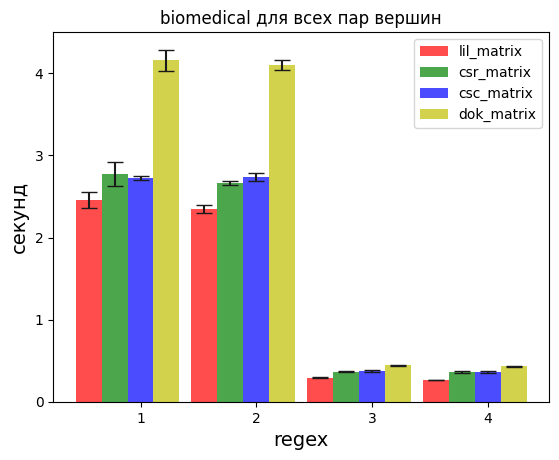

[2022-10-19 21:34:40]>INFO>Found graph with name='funding'
[2022-10-19 21:34:41]>INFO>Load archive graph_archive=WindowsPath('c:/users/slava/documents/github/formal-lang-course/venv/lib/site-packages/cfpq_data/data/funding.tar.gz')
[2022-10-19 21:34:41]>INFO>Unzip graph name='funding' to file graph=WindowsPath('c:/users/slava/documents/github/formal-lang-course/venv/lib/site-packages/cfpq_data/data/funding/funding.csv')
[2022-10-19 21:34:41]>INFO>Remove archive graph_archive=WindowsPath('c:/users/slava/documents/github/formal-lang-course/venv/lib/site-packages/cfpq_data/data/funding.tar.gz')
[2022-10-19 21:34:41]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x000002062B04FDC0> from path=WindowsPath('c:/users/slava/documents/github/formal-lang-course/venv/lib/site-packages/cfpq_data/data/funding/funding.csv')
[2022-10-19 21:34:41]>INFO>Generate set of source vertices of 778 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x000002062B04FDC0>

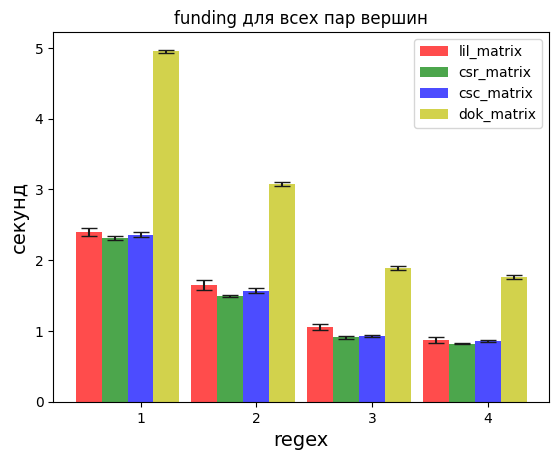

[2022-10-19 21:37:05]>INFO>Found graph with name='core'
[2022-10-19 21:37:06]>INFO>Load archive graph_archive=WindowsPath('c:/users/slava/documents/github/formal-lang-course/venv/lib/site-packages/cfpq_data/data/core.tar.gz')
[2022-10-19 21:37:06]>INFO>Unzip graph name='core' to file graph=WindowsPath('c:/users/slava/documents/github/formal-lang-course/venv/lib/site-packages/cfpq_data/data/core/core.csv')
[2022-10-19 21:37:06]>INFO>Remove archive graph_archive=WindowsPath('c:/users/slava/documents/github/formal-lang-course/venv/lib/site-packages/cfpq_data/data/core.tar.gz')
[2022-10-19 21:37:06]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x000002062A5E0F10> from path=WindowsPath('c:/users/slava/documents/github/formal-lang-course/venv/lib/site-packages/cfpq_data/data/core/core.csv')
[2022-10-19 21:37:06]>INFO>Generate set of source vertices of 1323 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x000002062A5E0F10> for multiple-source ev

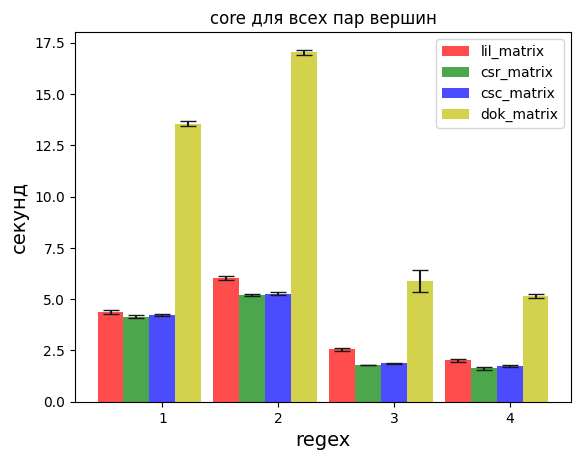

In [53]:
import logging
from scipy import mean
from cfpq_data import generate_multiple_source_percent
from project.__main__ import *
logging.getLogger("cfpq_data").disabled = True

def experiment(percents=None, separated=True, matrix_types=None, taskn=1):
    if percents is None:
        percents = [100]
    if matrix_types is None:
        matrix_types = [lil_matrix, csr_matrix, csc_matrix, dok_matrix]

    def regex_for_graph(gr):
        ls = list()
        for edge in gr.edges(data="label"):
            ls.append(edge[2])
        ls = [label for (label, _) in Counter(ls).most_common(4)]
        return [Regex(f'({ls[1]}|{ls[2]}|{ls[3]})*{ls[0]}'),
                Regex(f'({ls[0]}|{ls[1]}|{ls[2]})({ls[0]}|{ls[1]}|{ls[2]})*{ls[3]}'),
                Regex(f'({ls[0]} {ls[1]})* ({ls[0]} {ls[2]})*'),
                Regex(f'{ls[0]} {ls[2]} ({ls[0]}|{ls[3]})*')]

    print()
    graphs = ['biomedical', 'funding', 'core']
    # table = list()
    for graph_name in graphs:
        graph = gm.get_graph_by_name(graph_name)
        start_states = generate_multiple_source_percent(graph, percents[0], seed=3)
        bool_matrix_for_graph = BooleanMatrixAutomata(
            build_nfa_from_graph(graph, None, None), matrix_types[0]
        )
        regexes = regex_for_graph(graph)
        t = {per: {mat: {mean: [], tstd: []} for mat in matrix_types} for per in percents}
        for nr, regex in enumerate(regexes):
            bool_matrix_for_regex = BooleanMatrixAutomata(build_minimal_dfa_from_regex(regex), matrix_types[0])
            for per in percents:
                for mat_type in matrix_types:
                    times = list()
                    for i in range(5):
                        bool_matrix_for_graph.type_of_matrix = mat_type
                        bool_matrix_for_graph.start_state_indexes = generate_multiple_source_percent(graph, per, seed=3)
                        bool_matrix_for_regex.type_of_matrix = mat_type
                        start_time = time.time()
                        bool_matrix_for_graph.bfs_based_rpq(bool_matrix_for_regex, separated)
                        times.append(time.time() - start_time)
                    mean_t = mean(times)
                    tstd_t = tstd(times)
                    # table.append([graph_name, nr, mat_type.__name__, f'{mean_t:.7f}', f'{tstd_t:.7f}'])
                    t[per][mat_type][mean].append(mean_t)
                    t[per][mat_type][tstd].append(tstd_t)

        index = np.arange(0, 5, 1.25)
        bw = 0.28
        # plt.axis([0, 5, 0, 0.04])
        colors = ['r', 'g', 'b', 'y']

        title = graph_name
        if taskn == 1:
            plt.xticks(index + 2 * bw, [1, 2, 3, 4])
            title += ' для всех пар вершин'
            plt.xlabel("regex", fontsize=14)
            for i, mat in enumerate(matrix_types):
                plt.bar(index + i * bw, t[percents[0]][mat][mean], bw, yerr=t[percents[0]][mat][tstd],
                        error_kw={'ecolor': '0.1', 'capsize': 6}, alpha=0.7, color=colors[i], label=mat.__name__)
        else:
            plt.xticks(index + 2 * bw, percents)
            plt.xlabel("percent", fontsize=14)
            for i, per in enumerate(percents):
                plt.bar(index + i * bw, t[per][lil_matrix][mean], bw, alpha=0.7, color=colors[i], label=per)
            if taskn == 2:
                title += ' для всего множества стартовых вершин' 
            else:
                title += ' для каждой из заданных стартовых вершин'
        plt.ylabel("секунд", fontsize=14)
        plt.title(title)
        plt.legend(loc=1)
        plt.show()


experiment()

Достижимость для всего множества заданных вершин:

[2022-10-19 21:43:58]>INFO>Found graph with name='biomedical'
[2022-10-19 21:43:58]>INFO>Load archive graph_archive=WindowsPath('c:/users/slava/documents/github/formal-lang-course/venv/lib/site-packages/cfpq_data/data/biomedical.tar.gz')
[2022-10-19 21:43:58]>INFO>Unzip graph name='biomedical' to file graph=WindowsPath('c:/users/slava/documents/github/formal-lang-course/venv/lib/site-packages/cfpq_data/data/biomedical/biomedical.csv')
[2022-10-19 21:43:58]>INFO>Remove archive graph_archive=WindowsPath('c:/users/slava/documents/github/formal-lang-course/venv/lib/site-packages/cfpq_data/data/biomedical.tar.gz')
[2022-10-19 21:43:58]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x000002062AD7C4F0> from path=WindowsPath('c:/users/slava/documents/github/formal-lang-course/venv/lib/site-packages/cfpq_data/data/biomedical/biomedical.csv')
[2022-10-19 21:43:58]>INFO>Generate set of source vertices of 85 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object

[2022-10-19 21:43:58]>INFO>Generate set of source vertices of 85 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x000002062AD7C4F0> for multiple-source evaluation
[2022-10-19 21:43:58]>INFO>Generate set of source vertices of 85 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x000002062AD7C4F0> for multiple-source evaluation
[2022-10-19 21:43:58]>INFO>Generate set of source vertices of 85 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x000002062AD7C4F0> for multiple-source evaluation
[2022-10-19 21:43:58]>INFO>Generate set of source vertices of 85 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x000002062AD7C4F0> for multiple-source evaluation
[2022-10-19 21:43:59]>INFO>Generate set of source vertices of 85 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x000002062AD7C4F0> for multiple-source evaluation
C:\Users\slava\AppData\Local\Temp\ipykernel_17352\1829465912.py:46: De

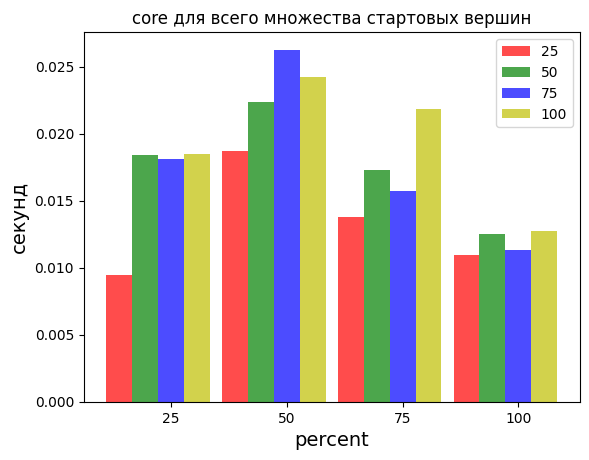

In [54]:
experiment([25, 50, 75, 100], False, [lil_matrix], taskn=2)

Достижимость для каждой из заданного множества стартовых вершин:

[2022-10-19 21:44:03]>INFO>Found graph with name='biomedical'
[2022-10-19 21:44:03]>INFO>Load archive graph_archive=WindowsPath('c:/users/slava/documents/github/formal-lang-course/venv/lib/site-packages/cfpq_data/data/biomedical.tar.gz')
[2022-10-19 21:44:03]>INFO>Unzip graph name='biomedical' to file graph=WindowsPath('c:/users/slava/documents/github/formal-lang-course/venv/lib/site-packages/cfpq_data/data/biomedical/biomedical.csv')
[2022-10-19 21:44:03]>INFO>Remove archive graph_archive=WindowsPath('c:/users/slava/documents/github/formal-lang-course/venv/lib/site-packages/cfpq_data/data/biomedical.tar.gz')
[2022-10-19 21:44:03]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x000002062B9EAE80> from path=WindowsPath('c:/users/slava/documents/github/formal-lang-course/venv/lib/site-packages/cfpq_data/data/biomedical/biomedical.csv')
[2022-10-19 21:44:03]>INFO>Generate set of source vertices of 85 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object

[2022-10-19 21:44:04]>INFO>Generate set of source vertices of 85 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x000002062B9EAE80> for multiple-source evaluation
[2022-10-19 21:44:05]>INFO>Generate set of source vertices of 85 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x000002062B9EAE80> for multiple-source evaluation
[2022-10-19 21:44:05]>INFO>Generate set of source vertices of 85 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x000002062B9EAE80> for multiple-source evaluation
[2022-10-19 21:44:06]>INFO>Generate set of source vertices of 85 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x000002062B9EAE80> for multiple-source evaluation
C:\Users\slava\AppData\Local\Temp\ipykernel_17352\1829465912.py:46: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  mean_t = mean(times)
[2022-10-19 21:44:07]>INFO>Generate set of source vertices of

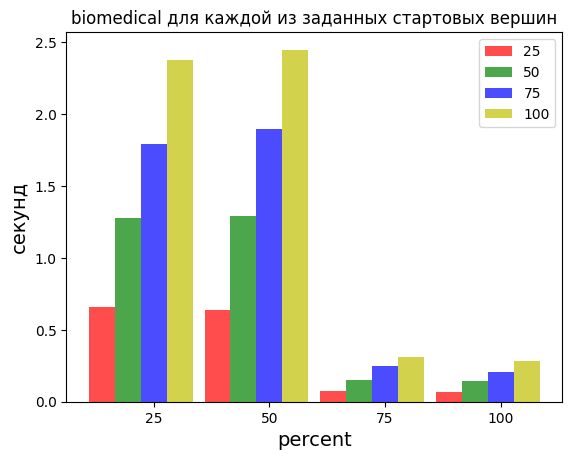

[2022-10-19 21:45:13]>INFO>Found graph with name='funding'
[2022-10-19 21:45:13]>INFO>Load archive graph_archive=WindowsPath('c:/users/slava/documents/github/formal-lang-course/venv/lib/site-packages/cfpq_data/data/funding.tar.gz')
[2022-10-19 21:45:13]>INFO>Unzip graph name='funding' to file graph=WindowsPath('c:/users/slava/documents/github/formal-lang-course/venv/lib/site-packages/cfpq_data/data/funding/funding.csv')
[2022-10-19 21:45:13]>INFO>Remove archive graph_archive=WindowsPath('c:/users/slava/documents/github/formal-lang-course/venv/lib/site-packages/cfpq_data/data/funding.tar.gz')
[2022-10-19 21:45:13]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x000002062A9F1880> from path=WindowsPath('c:/users/slava/documents/github/formal-lang-course/venv/lib/site-packages/cfpq_data/data/funding/funding.csv')
[2022-10-19 21:45:13]>INFO>Generate set of source vertices of 194 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x000002062A9F1880>

In [ ]:
experiment([25, 50, 75, 100], True, [lil_matrix], taskn=3)

Вывод
